# Проект "Прогнозирование ухода клиента из банка"  

__Цель:__ На основании исторических данных о поведении клиентов и расторжении договоров с банком, спрогнозировать уйдет ли клиент из банка в ближайшее время.    

__Задача:__ Сконструировать модель с метрикой F1 на тестовой выборке >= 0.59

__План проекта:__
- Загрузка и подготовка данных
- Исследование баланса классов, обучение модели без учета дисбаланса
- Улучшение качества модели, учитывая дисбаланс классов
- Поиск оптимальной модели
- Финальное тестирование
- Общий вывод  
  
__Акценты:__  
1. В проекте применены техники:  
   - Кодирования номинативных переменных  
   - Масштабирования числовых переменных  
   - Синтетического увеличения объема выборки   
   - Поиска порога вероятности, улучшающего показатели среднего гармонического      
   
2. В проекте рассмотрены модели: 
    - DecisionTreeClassifier
    - LogisticRegression
    - RandomForestClassifier

## Подготовка к исследованию

In [36]:
# Загрузка библиотек
!pip install imblearn -q

In [37]:
# Импорты
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import warnings

# Установки
warnings.filterwarnings('ignore') 
pd.set_option('display.float_format', '{:.1f}'.format)
sns.set_style('darkgrid')

# Константы
RS = 888

# Функции
def get_info():
    '''
    Получение информации о датасете
    '''
    display(data.sample(5))
    print(f'Количество объектов: {data.shape[0]}')
    print(f'Количество признаков: {data.shape[1]}', end='\n'*2)
    data.info(memory_usage='deep')
    display(data.describe().T)
    print(f'Доля пропусков по колонкам:\n{data.isna().sum() / data.shape[0] * 100}', end='\n'*2)
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')

def proba_func(features_test, target_test, model):
    '''
    Ищет оптимальный порог увеличивающий метрику f1
    '''
    probabilities_test = model.predict_proba(features_test)
    probabilities_test_ones = probabilities_test[:,1]

    counter = 0
    best_f1 = 0
    for threshold in np.arange(0,1.05,0.05):
        predicted_test = probabilities_test_ones > threshold
        f1 = f1_score(target_test, predicted_test)   
        counter +=  1
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = counter * 0.05 - 0.05
    return (f'Лучшее значение f1: {round(best_f1,3)} дает порог {round(best_threshold,2)}')  

def renew(target, features):
    '''
    Обновляет переменные features_train, target_train, features_test, target_test
    для корректного исследования моделей
    '''
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                   train_size=0.7, random_state=RS)
    features_test, features_valid, target_test, target_valid =  train_test_split(features_test, target_test, 
                                                                                  test_size=0.3, random_state=RS)
    ohe_features = ['geography','gender']
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
    encoder.fit(features[ohe_features])

    features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[ohe_features])
    features_train = features_train.drop(ohe_features, axis=1)

    features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[ohe_features])
    features_test = features_test.drop(ohe_features, axis=1)

    scaling_cols = ['credit_score', 'age', 'tenure',
              'balance', 'num_of_products', 'has_cr_card', 
              'is_active_member', 'estimated_salary']
    scaler = RobustScaler()

    features_train[scaling_cols] = scaler.fit_transform(features_train[scaling_cols])
    features_test[scaling_cols] = scaler.transform(features_test[scaling_cols])
    
    return features_train, target_train, features_test, target_test


## Знакомство с датасетом

### Получение основной информации

In [38]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv', index_col=['RowNumber'])

In [39]:
data.columns = data.columns.str.lower()
data.index.name = 'index'
data = data.rename(columns={'customerid':'customer_id',
                           'creditscore':'credit_score',
                           'numofproducts':'num_of_products',
                           'hascrcard':'has_cr_card',
                           'isactivemember':'is_active_member',
                           'estimatedsalary':'estimated_salary'})


In [40]:
get_info()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
index,,,,,,,,,,,,,
3971,15634310,Ko,509,France,Male,30,6.0,0.0,2,1,0,180598.9,0
788,15694366,Hou,714,Germany,Male,42,2.0,177640.1,1,0,1,47166.6,0
3438,15619436,Pan,700,France,Female,32,3.0,0.0,1,0,0,95740.4,0
9837,15777958,Ch'ien,587,France,Male,39,10.0,0.0,2,1,1,170409.5,0
761,15583212,Chidozie,600,France,Female,43,5.0,134022.1,1,1,0,194764.8,0


Количество объектов: 10000
Количество признаков: 13

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            9091 non-null   float64
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 2.6 MB


,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,15690940.6,71936.2,15565701.0,15628528.2,15690738.0,15753233.8,15815690.0
credit_score,10000.0,650.5,96.7,350.0,584.0,652.0,718.0,850.0
age,10000.0,38.9,10.5,18.0,32.0,37.0,44.0,92.0
tenure,9091.0,5.0,2.9,0.0,2.0,5.0,7.0,10.0
balance,10000.0,76485.9,62397.4,0.0,0.0,97198.5,127644.2,250898.1
num_of_products,10000.0,1.5,0.6,1.0,1.0,1.0,2.0,4.0
has_cr_card,10000.0,0.7,0.5,0.0,0.0,1.0,1.0,1.0
is_active_member,10000.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
estimated_salary,10000.0,100090.2,57510.5,11.6,51002.1,100193.9,149388.2,199992.5
exited,10000.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0


Доля пропусков по колонкам:
customer_id        0.0
surname            0.0
credit_score       0.0
geography          0.0
gender             0.0
age                0.0
tenure             9.1
balance            0.0
num_of_products    0.0
has_cr_card        0.0
is_active_member   0.0
estimated_salary   0.0
exited             0.0
dtype: float64

Количество явных дубликатов: 0


In [41]:
# Проверка на дубликаты по customer_id
data.duplicated('customer_id').sum()

# Удаление данных, не влияющих на предсказание модели
data = data.drop(['customer_id','surname'], axis=1)

# Проверка на дубликаты без удаленного признака
data.duplicated().sum()

0

__Вывод:__  
- 10 000 объектов, 13 признаков
- Есть 9% пропусков в колонке tenure
- 25% квартиль признака balance имеет значение 0
- Тип данных в колонке tenure - float
- Отсутствует описание критериев присвоения признака is_active_member
- Целевой признак находится в колонке exited  
- Явные дубликаты отсутствуют
- Дубликаты по customer_id отсутствуют  
- Дубликаты без учета customer_id отсутствуют   
---
Удалены нерелевантные признаки customer_id, surname

### Графический анализ

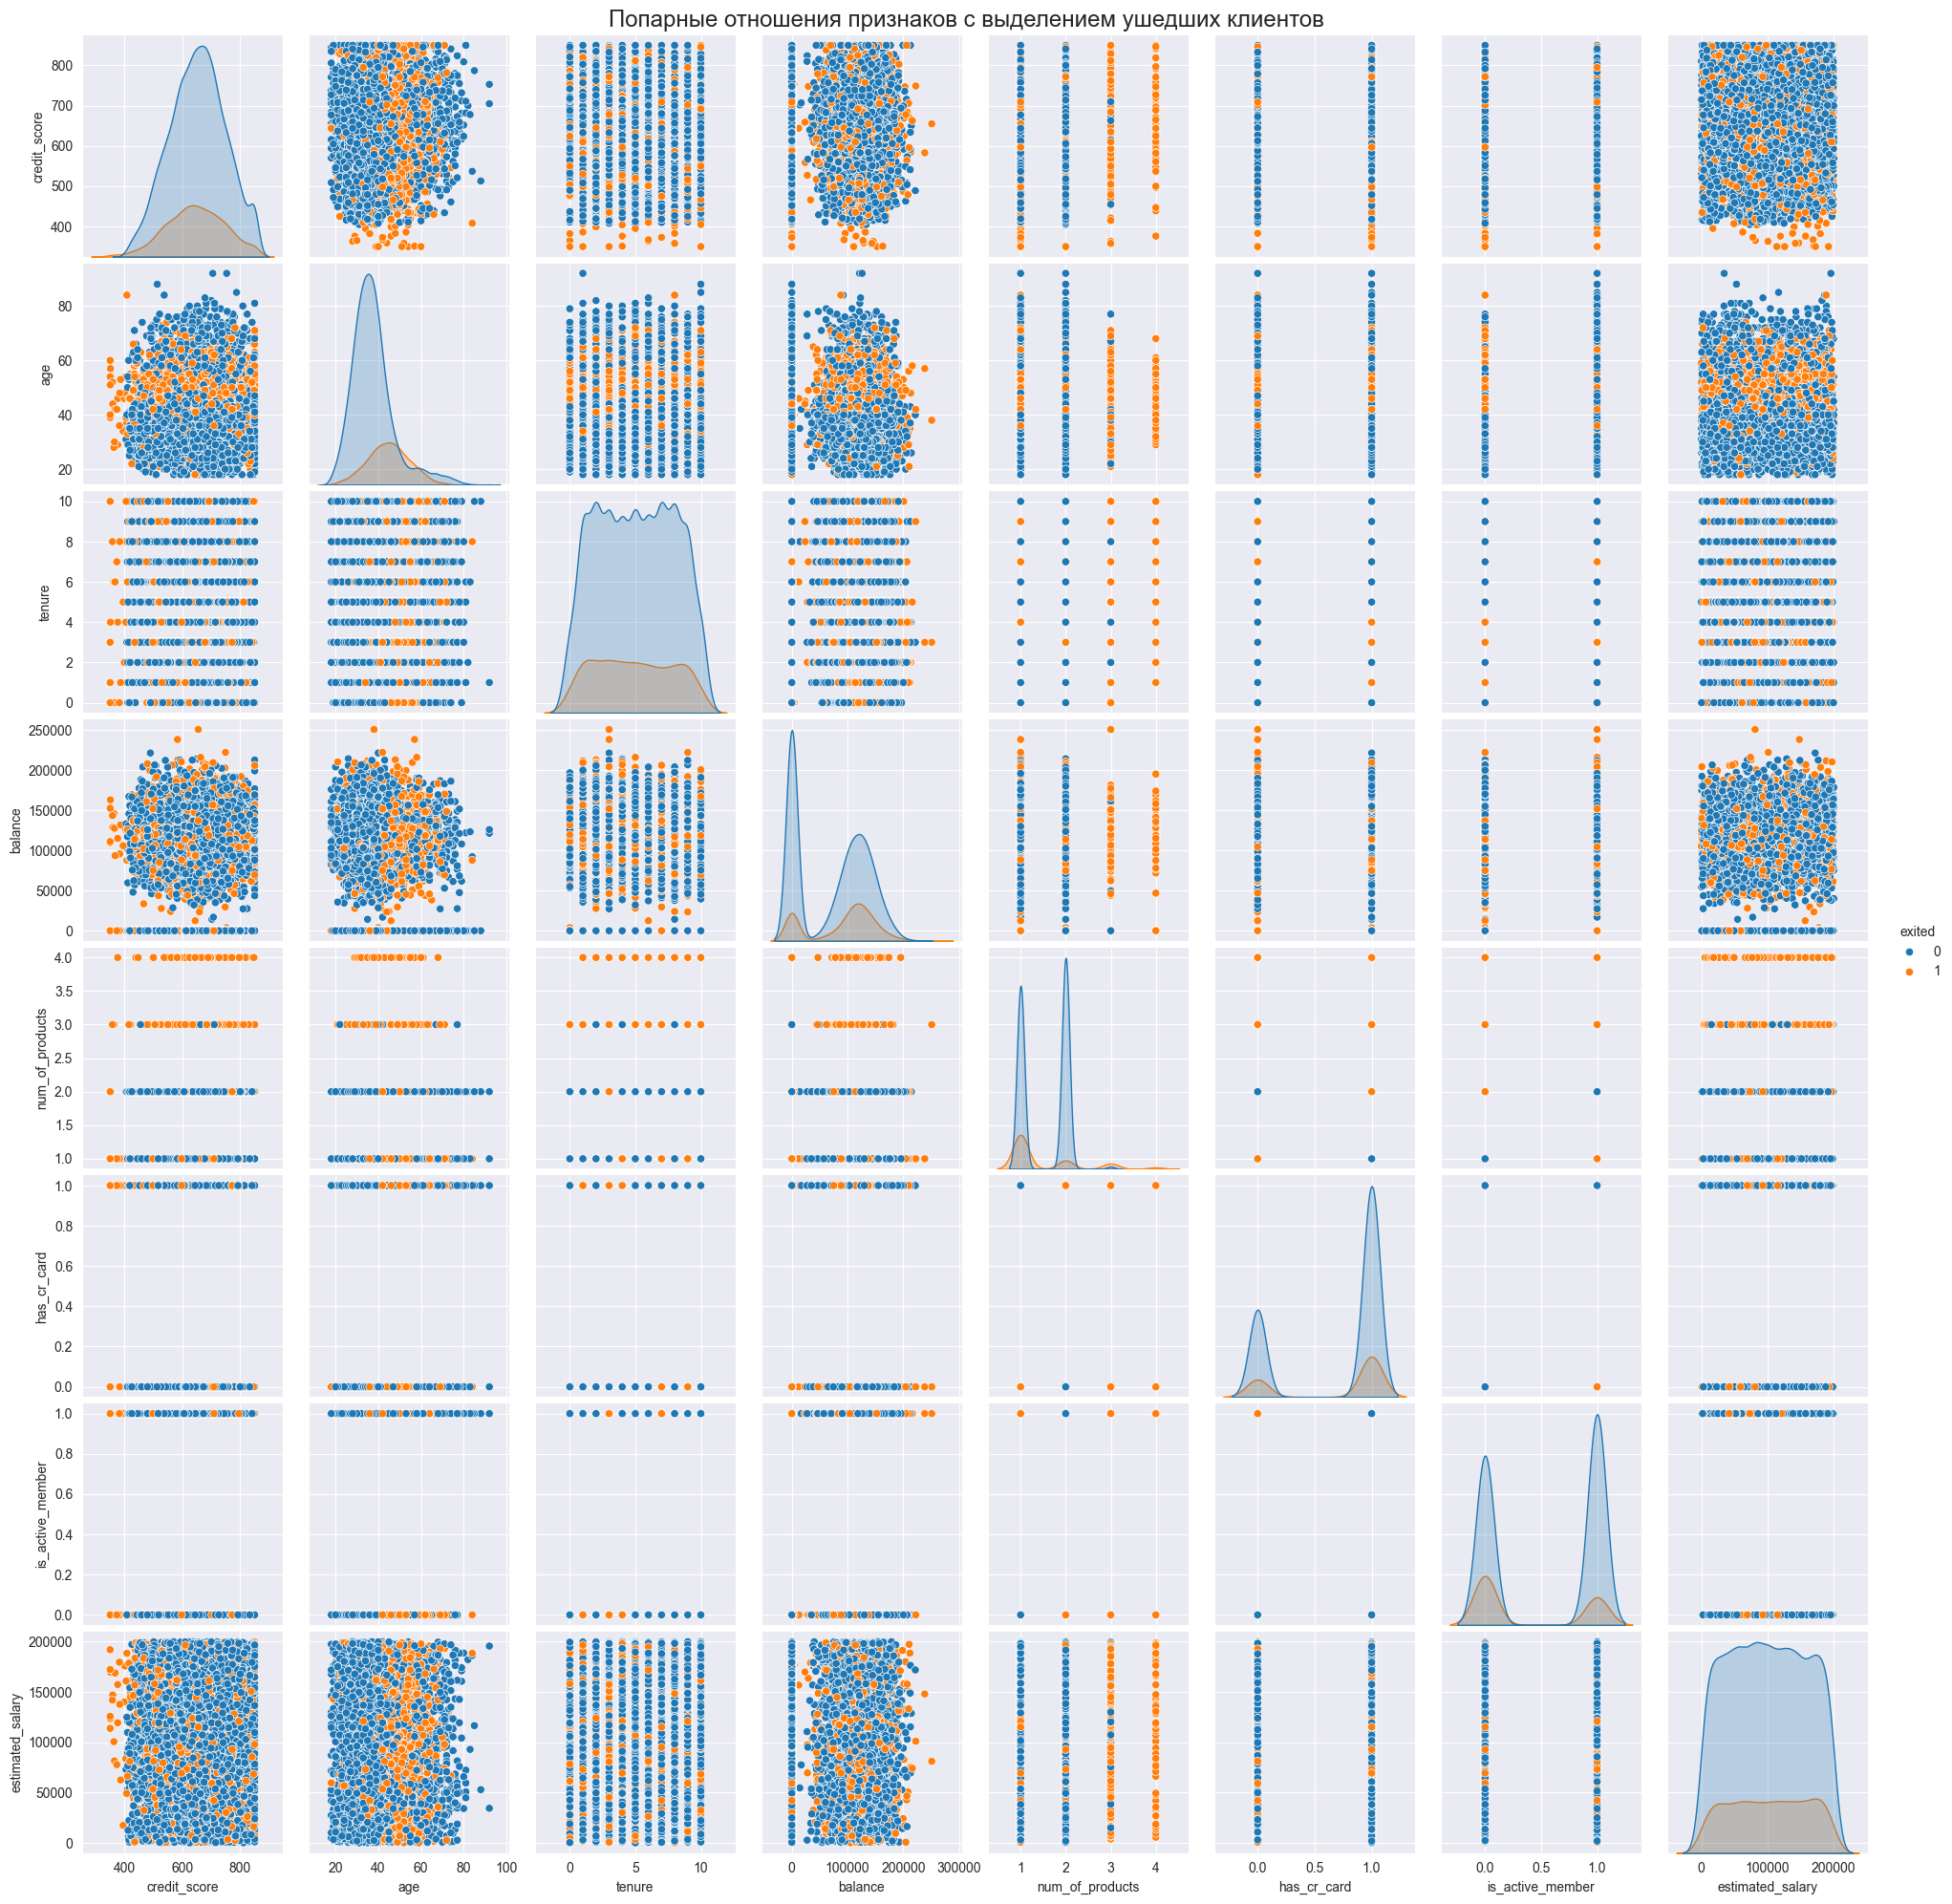

In [42]:
sns.pairplot(data, hue='exited')
plt.suptitle('Попарные отношения признаков с выделением ушедших клиентов', y=1, fontsize='xx-large');

- Чаще закрывают счета клиенты в возрасте 40-60 лет  
- Если кредитный рейтинг низкий, больше шансов, что будет закрыт счет
- Чем больше продуктов, тем выше шанс закрытия счета  
- Средний возраст клиента ~38 лет. Средний возраст бывшего клиента ~42 года      
---
- Бинарные признаки: has_cr_card, is_active_member, exited 
- Категориальные признаки: tenure, num_of_products
- Равномерное распределение: customer_id, estimated_salary  
- Распределение похожее на нормальное: credit_score, age, balance 
- Аномалии: creditscore (на максимальном значении), balance(на минимальном значении)

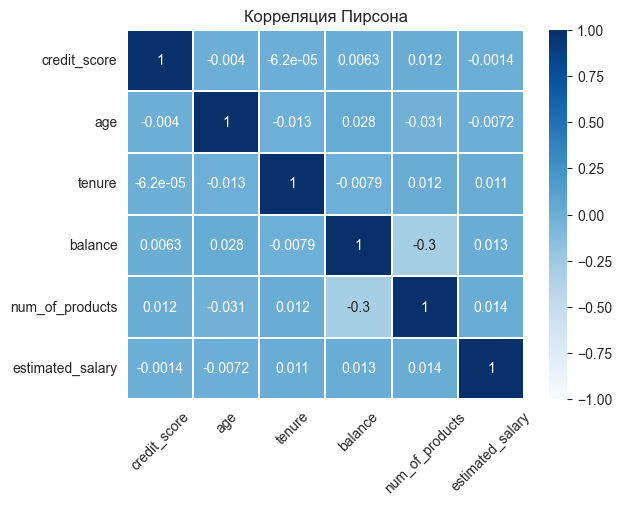

In [43]:
correlation_cols = ['credit_score','age','tenure', 'balance', 'num_of_products','estimated_salary']
sns.heatmap(data[correlation_cols].corr(), linewidth=0.1, annot=True,cmap='Blues', vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.title('Корреляция Пирсона');

- Корреляция отсутствует за исключением balance и num_of_product. Значение слабое - 30%

__Вывод:__  
- Выборка выглядит ровной, без существенных аномалий   
- Пропусков 9%
- Есть перекос в credit_score в правую сторону
- Есть отличия между средним и медианой в balance за счет большого количества нулевых счетов
- 25% клиентов не имеют остатков на счетах
- Клиентов, которые расторгли договор с банком, больше среди тех, кто пользовался 3 и более продуктами банка.    

### Обработка пропусков

In [44]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())
data['tenure'].isna().sum()
data['tenure'] =data['tenure'].astype('int64')

__Вывод:__  
- Учитывая равномерное распределение признака, пропуски заполнены медианным значением
- Признак переведен в целочисленный формат

### Анализ распределений

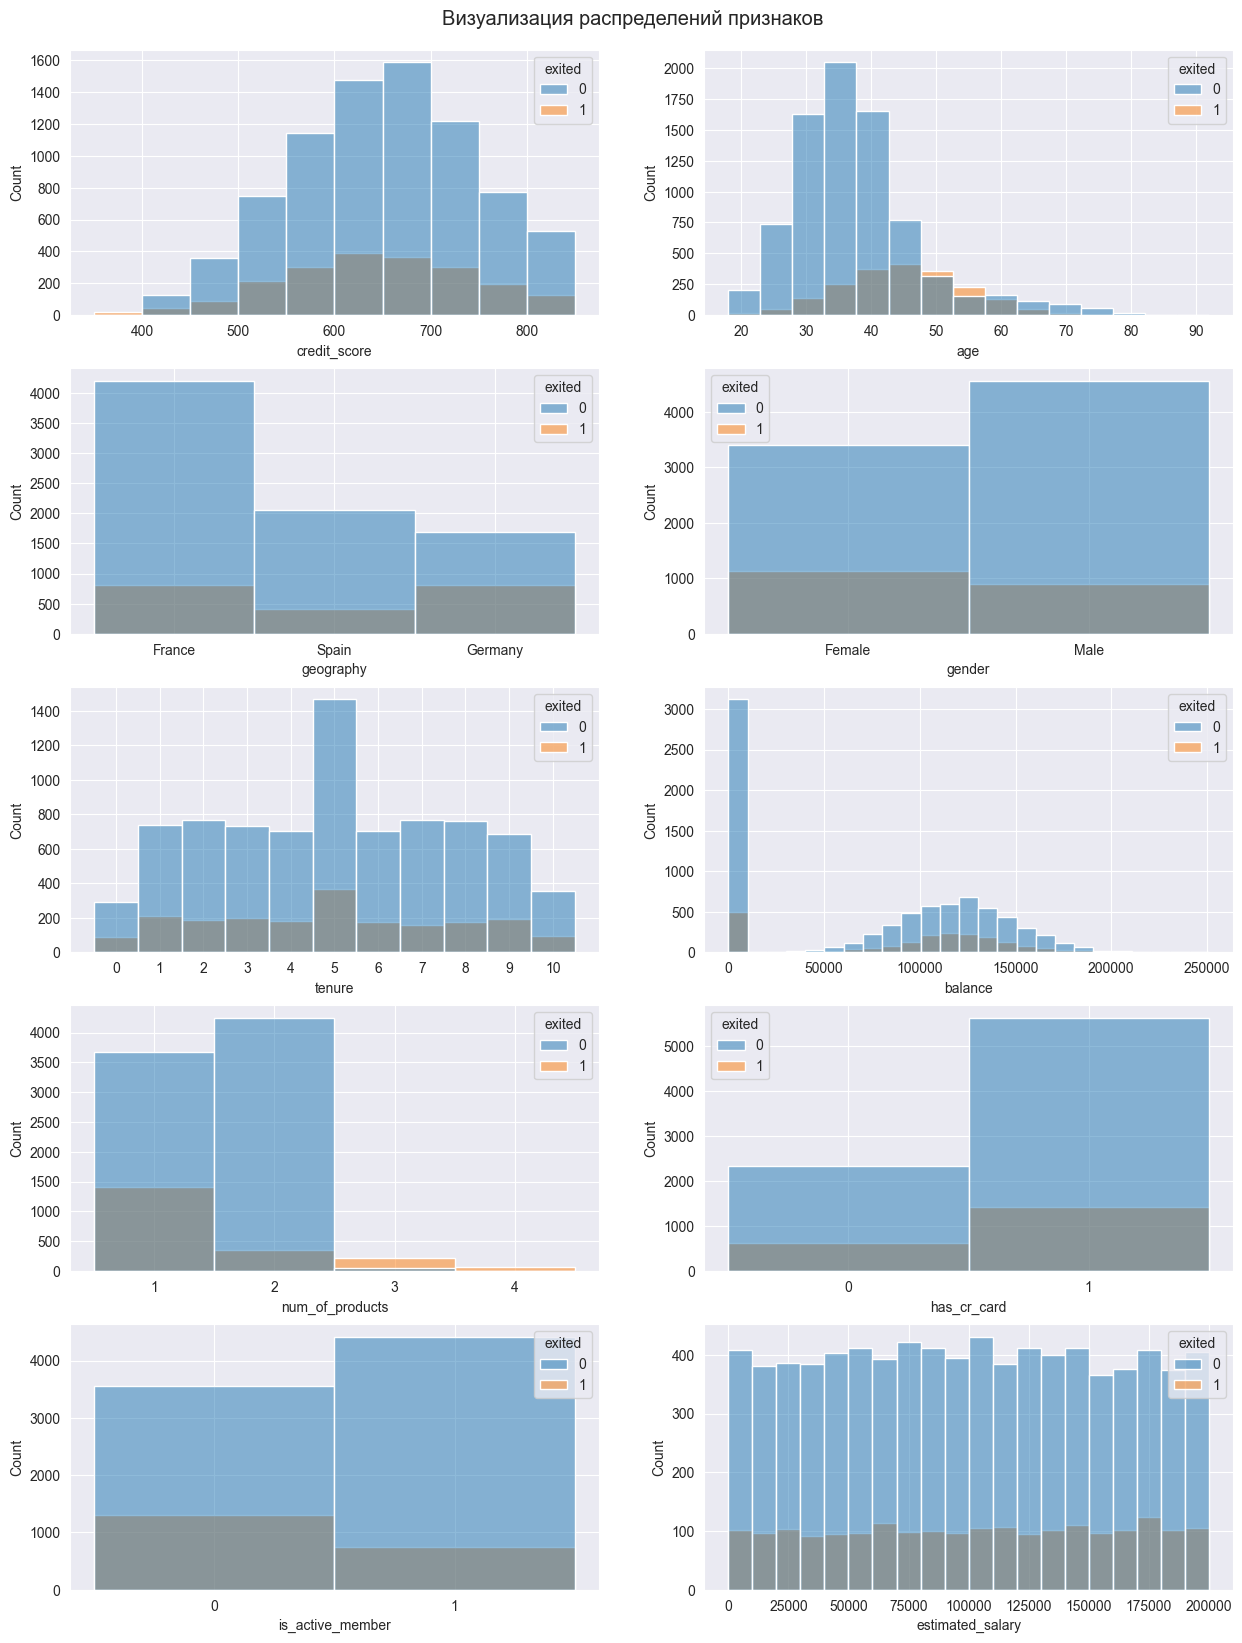

In [45]:
fig, axes = plt.subplots(5,2, figsize=(15,20))

sns.histplot(data, x='credit_score', binwidth=50, hue='exited', ax=axes[0][0])
sns.histplot(data, x='age', binwidth=5, hue="exited", ax=axes[0][1])
sns.histplot(data, x='geography', hue="exited", ax=axes[1][0])
sns.histplot(data, x="gender", hue="exited", ax=axes[1][1])
sns.histplot(data, x='tenure', hue='exited', ax=axes[2][0],discrete=True)
axes[2][0].set_xticks(range(0,11))
sns.histplot(data, x='balance', binwidth=10000, hue='exited', ax=axes[2][1])
sns.histplot(data, x='num_of_products', hue="exited", ax=axes[3][0], discrete=True)
axes[3][0].set_xticks([1,2,3,4])
sns.histplot(data, x='has_cr_card', hue="exited", ax=axes[3][1], discrete=True)
axes[3][1].set_xticks([0,1])
sns.histplot(data, x="is_active_member", hue="exited", ax=axes[4][0], discrete=True)
axes[4][0].set_xticks([0,1])
sns.histplot(data, x='estimated_salary', binwidth=10000, hue='exited', ax=axes[4][1]);
plt.suptitle('Визуализация распределений признаков', y = 0.9, fontsize='x-large');

__Вывод:__  

У ушедших и оставшихся клиентов в признаке:   
- credit_score распределения совпадают, имеют нормальный вид. 
- age распределения напоминают нормальные, средний возраст ушедших смещен вправо относительно оставшихся.  
- количество клиентов из Франции превышает количество клиентов из Германии и Испании, причем доля ушедших больше всего в Германии  
- мужчин больше чем женщин, причем они более лояльны к банку  
- глубина проникновения в клиента не высокая: большая часть пользуется 1-2 продуктами. Причем среди тех, кто пользуется 3 и 4 продуктами доля ушедших превышает долю оставшихся.  
- большая доля ушедших среди неактивных клиентов чем среди активных

### Вывод
- Выборка содержит 10 000 объектов, 13 признаков
- Поставленная задача - задача бинарной классификации
- Поиск дубликатов таковых не выявил
- Исправлены пропуски и тип данных в признаке tenure
- Проведена визуализация данных 
  
__Акценты__: 
- Большое количество нулевых остатков
- Малое количество клиентов, пользующихся более 2 продуктов банка
- Равномерное распределение оценочной заработной платы клиентов  
- Клиентов, которые расторгли договор с банком, больше среди тех, кто пользовался 3 и более продуктами банка.   

## Подготовка к моделированию

### Разделение на выборки

In [46]:
# Создание целевой и исходной переменных
target = data['exited']
features = data.drop('exited',  axis=1)

# Разделение на тренировочную, валидационную и тестовую выборки 60/20/20
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                               train_size=0.7, random_state=RS)
features_test, features_valid, target_test, target_valid =  train_test_split(features_test, target_test, 
                                                                              test_size=0.3, random_state=RS)

print(f'Размеры выборок:\nТренировочная - {features_train.shape[0]}')
print(f'Тестовая - {features_test.shape[0]}')
print(f'Валидационная - {features_valid.shape[0]}')

Размеры выборок:
Тренировочная - 7000
Тестовая - 2100
Валидационная - 900


### Энкодинг

In [47]:
ohe_features = ['geography','gender']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
encoder.fit(features[ohe_features])

features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[ohe_features])
features_train = features_train.drop(ohe_features, axis=1)

features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[ohe_features])
features_test = features_test.drop(ohe_features, axis=1)

features_valid[encoder.get_feature_names_out()] = encoder.transform(features_valid[ohe_features])
features_valid = features_valid.drop(ohe_features, axis=1)

### Масштабирование

In [48]:
scaling_cols = ['credit_score', 'age', 'tenure',
              'balance', 'num_of_products', 'has_cr_card', 
              'is_active_member', 'estimated_salary']
scaler = RobustScaler()

features_train[scaling_cols] = scaler.fit_transform(features_train[scaling_cols])
features_test[scaling_cols] = scaler.transform(features_test[scaling_cols])
features_valid[scaling_cols] = scaler.transform(features_valid[scaling_cols])

### Вывод
Данные подготовлены к обучению моделей:
- Проведен энкодинг техникой OHE
- Выборки разделены на тестовую, валидационную и тренировочную в соотношении 60/20/20
- Проведено масштабирование данных c использованием RobustScaler

## Моделирование

### Дамми-модель

In [49]:
constant_model = pd.Series([1] * len(target_test))
f1 = f1_score(target_test, constant_model)
print(f'Метрика f1: {round(f1,3)}')

Метрика f1: 0.348


__Вывод:__    
- Дамми-модель предсказывает уход всех клиентов. При данном подходе значение среднего гармонического составляет 34.8%  
- Основная задача проекта - метрика f1 >= 0.59  
- Первичная задача - превышение порога дамми-модели

### DecisionTreeClassifier

In [50]:
model = DecisionTreeClassifier(random_state=RS)
param_grid = {
    'criterion' : ['gini','entropy','log_loss'],
    'max_depth' : [1,25,50,75,100,150], 
    'max_leaf_nodes' : [2,25,50,75,100,150],
    'class_weight' : [None,'balanced'],
    'min_samples_split' : [2,5,10,15,30],
    'min_samples_leaf' : [1,3,5,10,25,50],
}

In [51]:
search = RandomizedSearchCV(model,
                            param_distributions=param_grid, 
                            n_jobs=-1, cv=5, 
                            random_state=RS)

In [52]:
search.fit(features_train, target_train)
predicted = pd.Series(search.predict(features_test))
f1 = f1_score(target_test, predicted)
print(f'Метрика f1: {round(f1,3)}\nХарактеристики модели:\n{search.best_estimator_}')

Метрика f1: 0.549
Характеристики модели:
DecisionTreeClassifier(criterion='log_loss', max_depth=50, max_leaf_nodes=25,
                       min_samples_leaf=3, min_samples_split=15,
                       random_state=888)


__Вывод:__
- Использован RandomizedSearch  
- Результат метрики f1 превышает результат дамми-модели в 1.5 раза  
- Целевой порог (0.59) не достигнут


#### Выравнивание баланса классов

In [53]:
# Текущий баланс классов
target_train.value_counts(normalize=True)

exited
0   0.8
1   0.2
Name: proportion, dtype: float64

In [54]:
# Апсэмплинг
sampler = SMOTE(random_state=RS, n_jobs=-1)
features_train, target_train = sampler.fit_resample(features_train, target_train)

# Баланс классов на выходе
target_train.value_counts(normalize=True)

exited
1   0.5
0   0.5
Name: proportion, dtype: float64

In [55]:
search.fit(features_train, target_train)
predicted = pd.Series(search.predict(features_test))
f1 = f1_score(target_test, predicted)
print(f'Метрика f1: {round(f1,3)}\nХарактеристики модели:\n{search.best_estimator_}')

Метрика f1: 0.597
Характеристики модели:
DecisionTreeClassifier(max_depth=100, max_leaf_nodes=75, min_samples_split=30,
                       random_state=888)


__Вывод:__  
- Использован SMOTE  
- Выровнен баланс классов  
- Метрика f1  превышает заданный порог

#### Поиск порога

In [56]:
proba_func(features_test, target_test, search.best_estimator_)

'Лучшее значение f1: 0.604 дает порог 0.4'

__Вывод:__  
- С помощью поиска порога удалрось улучшить метрику еще почти на 1%.

#### Вывод
- Использован SMOTE
- Выравнен баланс классов
- Осуществлен поиск порога 
---
- Метрика f1 = 0.604, порог = 0.4

### LogisticRegression

In [57]:
features_train, target_train, features_test, target_test = renew(target, features)

model = LogisticRegression(random_state=RS, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
predicted = pd.Series(model.predict(features_test))
f1 = f1_score(target_test, predicted)

    
print(f'Метрика f1: {round(f1,3)}\nХарактеристики модели:\n{model.get_params}')

Метрика f1: 0.291
Характеристики модели:
<bound method BaseEstimator.get_params of LogisticRegression(max_iter=1000, random_state=888, solver='liblinear')>


__Выводы:__
- Результат не превышает порог дамми-модели

#### Выравнивание баланса классов

In [58]:
sampler = SMOTE(random_state=RS, n_jobs=-1)
features_train, target_train = sampler.fit_resample(features_train, target_train)
target_train.value_counts(normalize=True)

# Переобучение модели

model.fit(features_train, target_train)
predicted = pd.Series(model.predict(features_test))

#Результаты переобучения

f1 = f1_score(target_test, predicted)
print(f'Метрика f1: {round(f1,3)}\nХарактеристики модели:\n{model.get_params}')

Метрика f1: 0.52
Характеристики модели:
<bound method BaseEstimator.get_params of LogisticRegression(max_iter=1000, random_state=888, solver='liblinear')>


__Вывод:__  
- Использован SMOTE  
- Выровнен баланс классов  
- Метрика f1  превышает порог дамми-модели

#### Поиск порога

In [59]:
# Определение лучшего порога
proba_func(features_test, target_test, model)

'Лучшее значение f1: 0.535 дает порог 0.55'

__Вывод:__  
- С помощью поиска порога удалрось улучшить метрику еще на 1.5%.
- Целевой порог (0.59) преодален не был

#### Вывод
- Использован SMOTE
- Выравнен баланс классов
- Осуществлен поиск порога 
---
- Метрика f1 = 0.535, порог = 0.55

### RandomForestClassifier

In [60]:
features_train, target_train, features_test, target_test = renew(target, features)
model = RandomForestClassifier(random_state=RS, n_jobs=-1)
param_grid = {
    'n_estimators' : range(1,102,10),
    'criterion' : ['gini','entropy','log_loss'],
    'max_depth' : [1,25,50,75,100,150], 
    'max_leaf_nodes' : [2,25,50,75,100,150],
    'class_weight' : [None,'balanced'],
    'min_samples_split' : [2,5,10,15,30],
    'min_samples_leaf' : [1,3,5,10,25,50]
}

search = RandomizedSearchCV(model,
                            param_distributions=param_grid, 
                            n_jobs=-1, cv=5, 
                            random_state=RS)


search.fit(features_train, target_train)
predicted = pd.Series(search.predict(features_test))
f1 = f1_score(target_test, predicted)

print(f'Метрика f1: {round(f1,3)}\nХарактеристики модели:\n{search.best_estimator_}')

Метрика f1: 0.498
Характеристики модели:
RandomForestClassifier(criterion='log_loss', max_depth=75, max_leaf_nodes=50,
                       min_samples_leaf=3, min_samples_split=5, n_estimators=31,
                       n_jobs=-1, random_state=888)


__Вывод:__
- Использован RandomizedSearch  
- Результат метрики f1 превышает результат дамми-модели примерно на 10%  
- Целевой порог (0.59) не достигнут


#### Выравнивание баланса классов

In [61]:
sampler = SMOTE(random_state=RS, n_jobs=-1)
features_train, target_train = sampler.fit_resample(features_train, target_train)
target_train.value_counts(normalize=True)

# Переобучение модели

search.fit(features_train, target_train)
predicted = pd.Series(search.predict(features_test))

#Результаты переобучения

f1 = f1_score(target_test, predicted)
print(f'Метрика f1: {round(f1,3)}\nХарактеристики модели:\n{search.best_estimator_}')

Метрика f1: 0.647
Характеристики модели:
RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=150, max_leaf_nodes=100, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=101, n_jobs=-1,
                       random_state=888)


__Вывод:__  
- Использован SMOTE  
- Выровнен баланс классов  
- Метрика f1  превышает заданный порог

#### Поиск порога

In [62]:
proba_func(features_test, target_test, search.best_estimator_)

'Лучшее значение f1: 0.647 дает порог 0.5'

__Вывод:__  
- В результате поиска порога результат не поменялся

#### Вывод
- Использован SMOTE
- Выравнен баланс классов
- Осуществлен поиск порога 
---
- Метрика f1 = 0.647, порог = 0.5

### Вывод
-Изучено три модели, ко всем применена техника SMOTE, поиск порога.  
-Результаты:   
   - DecisionTreeClassifier - 0.604
   - LogisticRegression  - 0.535
   - RandomForestClassifier - 0.647

## Финальное тестирование

In [63]:
final_prediction = search.best_estimator_.predict(features_valid)
final_f1 = f1_score(target_valid, final_prediction)
print(f'Метрика f1: {round(final_f1,3)}')

Метрика f1: 0.608


In [64]:
proba_func(features_valid, target_valid, search.best_estimator_)

'Лучшее значение f1: 0.608 дает порог 0.5'

## Общий вывод: 
- Предоставлены данные по 10 000 клиентам из регионов присутствия банка - Франция, Германия и Испания. 
- Проведена корректировка пропущенных значений, поиск дубликатов, визуализация данных.
- Сформулированы промежуточные выводы, сделаны акценты для заказчика:
    - Доля "ушедших" значительно превышает долю "оставшихся" среди тех клиентов, кто пользуется 3 или 4 продуктами
    - Сотношение "ушедших"/"оставшихся" в Германии наиболее негативное.
    - Большое количество нулевых остатков
    - Малое количество клиентов, пользующихся более 2 продуктов банка
    - Значения в колонке "EstimatedSalary" не подчиняются закону нормального распределеня, а больше напоминают равномерное распределение, что наводит на вопрос, корректно ли банк проводит оценку заработной платы своих клиентов.  
    
- Выборка была разделена на три (тренировочная, валидационная, тестовая) в соотношении.
- К данным применена техника прямого кодирования и z- стандартизация.
- Было рассмотрено три модели классификации (RandomForestClassifier, LogisticRegression, DecisionTreeClassifier).
- В рамках рассмотрения осуществлен перебор гиперпараметров и апсэмплинг.
- Проводились замеры метрики f1
---
Лучшим вариантом оказалась модель RandomForestClassifier после применения техники SMOTE с параметрами:   
- class_weight='balanced', 
- criterion='log_loss',
- max_depth=150, 
- max_leaf_nodes=100, 
- min_samples_leaf=10,
- min_samples_split=5, 
- n_estimators=101

На тестовой выборке контрольный замер f1 показал значение 0.647, что превышает целевой порог 0.59.
На валидационной выборке результат немного снизаился и составил 0.608.
